# 1. Importing Libraries

In [45]:
# Importing Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import transforms
from torchmetrics import Accuracy
from torchinfo import summary
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime

# 2. Setting up the device

In [46]:
# Setting Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 3. Preparing the test_data

In [47]:
# Preparing Input Data
# prepare the dataset MNIST(1x28x28) -> (3x224x224) for AlexNet
# Upscale the grayscale images to RGB size
upscale_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])  # Normalize to [-1, 1] range
])

In [48]:
# Load the dataset
test_data = datasets.MNIST(
    root='./dataset', 
    train=True, 
    transform=upscale_transform, 
    download=True)

# Dataset summary
print('Test dataset:')
print(' - Number of datapoints: {}'.format(len(test_data)))
print(' - Image Shape: {}'.format(test_data[0][0].shape))
print(' - Number of classes: {}'.format(len(test_data.classes)))
print(" - Samples number all classes: {}".format(test_data.targets.bincount()))

Test dataset:
 - Number of datapoints: 60000
 - Image Shape: torch.Size([3, 224, 224])
 - Number of classes: 10
 - Samples number all classes: tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])


In [49]:
# Dataset for visualization
test_data_vis = datasets.MNIST(
    root='./dataset', 
    train=True, 
    transform=upscale_transform, 
    download=True)

# get the 10 images from the test set for visualization
vis_size = 10
test_data_vis = torch.utils.data.Subset(test_data_vis, range(vis_size))

# Dataset summary
print('Test dataset for visualization:')
print(' - Number of datapoints: {}'.format(len(test_data_vis)))
print(' - Image Shape: {}'.format(test_data_vis[0][0].shape))

# loader
test_loader_vis = DataLoader(test_data_vis, batch_size=vis_size, shuffle=True)

Test dataset for visualization:
 - Number of datapoints: 10
 - Image Shape: torch.Size([3, 224, 224])


In [50]:
# Create dataloaders
BATCH_SIZE = 128 if torch.cuda.is_available() else 64
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# Dataloader summary
print('Test dataloader:')
print(' - Number of batches: {}'.format(len(test_loader)))

Test dataloader:
 - Number of batches: 469


# 4. Loading the model

In [51]:
# Define the model
# Define the model AlexNet specific for the transformed MNIST
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            # ============================================================================== #
            # 1st conv layer
            # input: 3x224x224 (upscaled from 1x28x28)
            # output: 96x55x55
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0, ),
            # activation function: ReLU
            nn.ReLU(),
            # max pooling layer with kernel size 3 and stride 2
            # output: 96x27x27
            nn.MaxPool2d(kernel_size=3, stride=2),
            # ============================================================================== #
            
            # ============================================================================== #
            # 2nd conv layer
            # input: 96x27x27
            # output: 256x27x27
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            # activation function: ReLU
            nn.ReLU(),
            # max pooling layer with kernel size 3 and stride 2
            # output: 256x13x13
            nn.MaxPool2d(kernel_size=3, stride=2),
            # ============================================================================== #
            
            # ============================================================================== #
            # 3rd conv layer
            # input: 256x13x13
            # output: 384x13x13
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            # activation function: ReLU
            nn.ReLU(),
            # ============================================================================== #
            
            # ============================================================================== #
            # 4th conv layer
            # input: 384x13x13
            # output: 384x13x13
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            # activation function: ReLU
            nn.ReLU(),
            # ============================================================================== #
            
            # ============================================================================== #
            # 5th conv layer
            # input: 384x13x13
            # output: 256x13x13
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            # activation function: ReLU
            nn.ReLU(),
            # max pooling layer with kernel size 3 and stride 2
            # output: 256x6x6
            nn.MaxPool2d(kernel_size=3, stride=2)
            # ============================================================================== #
        )

        self.classifier = nn.Sequential(
            # flatten
            nn.Flatten(), # 256*5*5 = 6400
            # ============================================================================== #
            # 1st fc layer Dense: 4096 fully connected neurons
            nn.Dropout(p=0.5), # dropout layer with p=0.5
            nn.Linear(in_features=256 * 5 * 5, out_features=4096), # 256*5*5
            nn.ReLU(),
            # ============================================================================== #
            
            # ============================================================================== #
            # 2nd fc layer Dense: 4096 fully connected neurons
            nn.Dropout(p=0.5), # dropout layer with p=0.5
            nn.Linear(in_features=4096, out_features=4096), # 4096
            nn.ReLU(),
            # ============================================================================== #
            
            # ============================================================================== #
            # 3rd fc layer Dense: 10 fully connected neurons
            nn.Linear(in_features=4096, out_features=num_classes) # 4096
            # ============================================================================== #

        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x

In [52]:
# Load the model
model = AlexNet().to(device)
print(model)

# Model summary
summary(model, input_size=(1, 3, 224, 224), verbose=2, device=device)

# Load the model weights
model.load_state_dict(torch.load(os.path.join('models', 'model_v1_2023_12_31-15_04_06.ckpt'), map_location=device))

# Set the model to evaluation mode
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=6400, out_features=4096, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=409

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=6400, out_features=4096, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=409

In [53]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)
accuracy = Accuracy(task='multiclass', num_classes=10).to(device)

In [54]:
# Log the test
date_time = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
test_folder_name = f"test_v1_{date_time}"
log_dir = os.path.join('test_logs', test_folder_name)
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

In [55]:
# Test the model
y_true = []
y_pred = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        # Move the data to device
        data = data.to(device)
        target = target.to(device)

        # Forward pass
        output = model(data)
        loss = loss_fn(output, target)
        acc = accuracy(output, target)
        
        # save the true and predicted labels for confusion matrix
        y_true.extend(target.cpu().numpy())
        y_pred.extend(torch.argmax(output, dim=1).cpu().numpy())

        # Log the test
        writer.add_scalar('Loss/test', loss.item(), batch_idx)
        writer.add_scalar('Accuracy/test', acc.item(), batch_idx)

        # Print the loss and accuracy
        if batch_idx % 100 == 0:
            print('Test Batch {}/{}: Loss: {:.6f}, Accuracy: {:.6f}'.format(
                batch_idx, len(test_loader), loss.item(), acc.item()))

Test Batch 0/469: Loss: 0.014331, Accuracy: 0.992188
Test Batch 100/469: Loss: 0.024321, Accuracy: 0.984375
Test Batch 200/469: Loss: 0.041839, Accuracy: 0.992188
Test Batch 300/469: Loss: 0.031895, Accuracy: 0.992188
Test Batch 400/469: Loss: 0.046616, Accuracy: 0.984375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

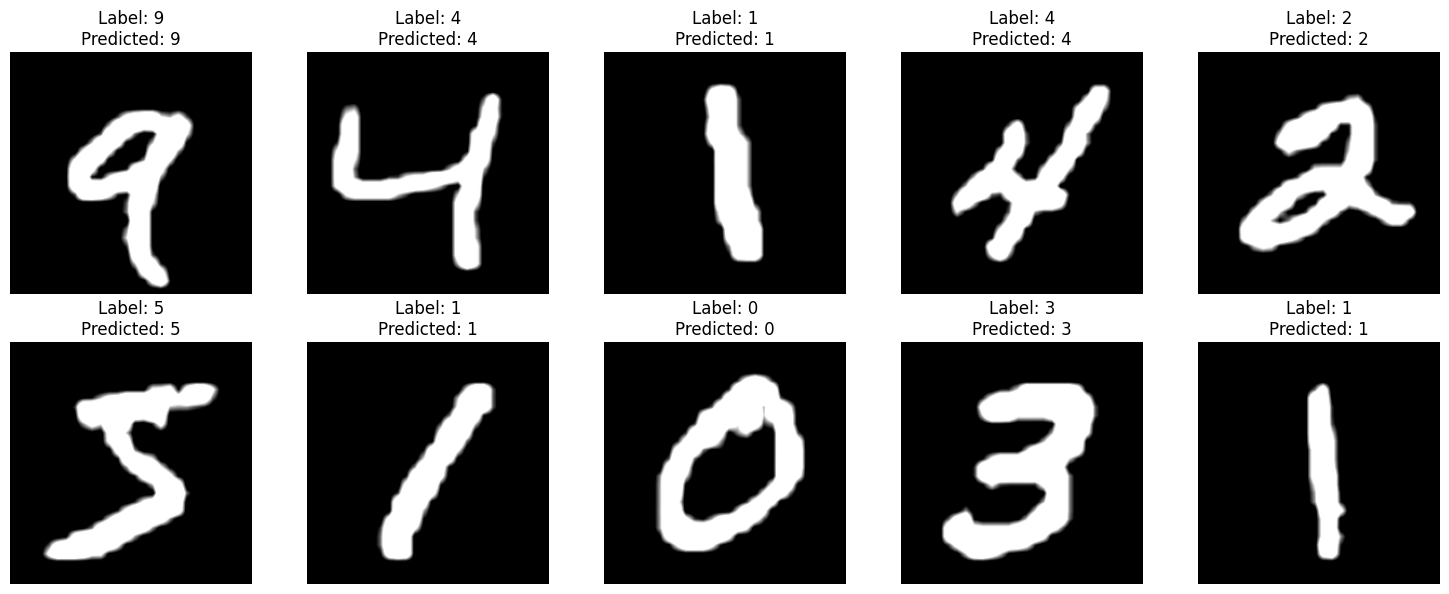

In [56]:
# Randomly select a batch of 10 images(split from the test set)
data_vis, target_vis = next(iter(test_loader_vis))
data_vis = data_vis.to(device)
target_vis = target_vis.to(device)

# plot the images in the batch, along with the corresponding labels(predicted and true), after prediction resizes the images to 28x28x1 to plot
with torch.no_grad():
    output_vis = model(data_vis)
    output_vis = torch.argmax(output_vis, dim=1)
    data_vis = data_vis.cpu().numpy()
    data_vis = np.transpose(data_vis, (0, 2, 3, 1))
    data_vis = np.squeeze(data_vis)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for idx, ax in enumerate(axes.flat):
        ax.imshow(data_vis[idx], cmap='gray')
        ax.set(title=f'Label: {target_vis[idx].item()}\nPredicted: {output_vis[idx].item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(log_dir, 'test_batch.png'))
    plt.show()

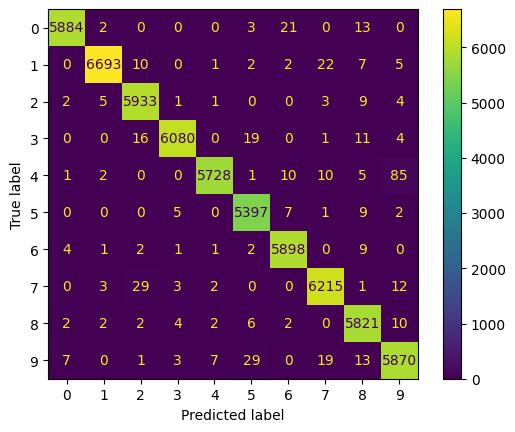

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5923
           1       1.00      0.99      1.00      6742
           2       0.99      1.00      0.99      5958
           3       1.00      0.99      0.99      6131
           4       1.00      0.98      0.99      5842
           5       0.99      1.00      0.99      5421
           6       0.99      1.00      0.99      5918
           7       0.99      0.99      0.99      6265
           8       0.99      0.99      0.99      5851
           9       0.98      0.99      0.98      5949

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000


In [57]:
# Confusion matrix all test data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.savefig(os.path.join(log_dir, 'confusion_matrix.png'))
plt.show()

print(classification_report(y_true, y_pred))


In [58]:
# Close the writer
writer.flush()
writer.close()

In [59]:
# Release GPU memory cache
torch.cuda.empty_cache()

# Release model from GPU memory
model = model.to('cpu')
model = None

# release all loaded data
data_vis = None
target_vis = None
data = None
target = None
data_loader = None
data_loader_vis = None
test_data = None
test_data_vis = None
test_loader = None
test_loader_vis = None

print('Done!')

Done!
